Importing all the necessary packages

In [3]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from tensorflow.python.keras import backend
from tensorflow.python.keras.engine import sequential
from tensorflow.python.keras.layers import Dense
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV
from tensorflow.python.keras.optimizer_v2 import adam as adam_v2
from tensorflow.python.keras.losses import categorical_crossentropy

Read in the data

In [28]:
df = pd.read_csv('finalData.csv')

C:\Users\ermun\AppData\Local\Temp\ipykernel_155488\941635897.py:1: DtypeWarning: Columns (15,21,23,40,42,47,48,52,76) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('finalData.csv')


Filter out data from 2014-2017 since the data is not complete for those years


In [5]:
df_filtered = df[(df['season_x'] > 2017)]

Filter by the 10 drivers to include in the network


In [6]:
drivers_to_include = [
    "Joey_Logano", "Denny_Hamlin", "Kyle_Busch", "Martin_Truex_Jr",
    "Brad_Keselowski", "Kyle_Larson", "Ryan_Blaney", "William_Byron"]

df_filtered = df_filtered[df_filtered['driver_id'].isin(drivers_to_include)]

Target Variables to include in the model

In [7]:
targetVariables = ['race_lap_len', 'race_track_surface', 'race_track_name', 
                   'finish_position', 'starting_position', 'driver_id', 'driver_name', 'driver_nationality', 'driver_number', 'race_laps_lead', 'points_earned', 'playoff_points_earned',
                   'race_laps_run', 'race_status', 'race_cautions', 'race_speed', 'race_lead_changes', 'race_date', 'number_of_leaders', 'race_car_count', 'race_pole_time', 'race_miles_completed', 'race_purse_completed',
                   'car', 'owner_id', 'sponsor', 'race_winner_name', 'race_winner_real_id', 'race_winner_starting_pos', 'race_winner_make', 'restrictor_plate', 'pole_winner_speed', 'race_speed', 'race_lap_len', 'number_of_caution_laps']

Filter the DataFrame to only include the target variables


In [8]:
df_filtered['winner'] = df_filtered['finish_position'].apply(lambda x: 1 if x == 1 else 0)

Filter out NTT, DFP, and MQ from 'race_pole_time' column


In [9]:
df_filtered['race_pole_time'] = df_filtered['race_pole_time'].replace(['NTT', 'DFP', 'MQ'], np.nan)
print(df_filtered.shape)
df_filtered = df_filtered.dropna(subset='race_pole_time')
print(df_filtered)

(1983, 82)
       season_x series_id_x                       race_id race_id_short  \
5947       2018           W              2018_DAYTONA_500       2018_01   
5948       2018           W              2018_DAYTONA_500       2018_01   
5951       2018           W              2018_DAYTONA_500       2018_01   
5962       2018           W              2018_DAYTONA_500       2018_01   
5963       2018           W              2018_DAYTONA_500       2018_01   
...         ...         ...                           ...           ...   
15482      2024           W  2024_CUP_SERIES_CHAMPIONSHIP       2024_36   
15489      2024           W  2024_CUP_SERIES_CHAMPIONSHIP       2024_36   
15493      2024           W  2024_CUP_SERIES_CHAMPIONSHIP       2024_36   
15495      2024           W  2024_CUP_SERIES_CHAMPIONSHIP       2024_36   
15499      2024           W  2024_CUP_SERIES_CHAMPIONSHIP       2024_36   

       finish_position  starting_position  driver_number driver_nationality  \
5947     

Define the X and y variables


In [10]:
X_target = df_filtered[targetVariables]
y = df_filtered['winner']

In [11]:
# Categorical variables to include in the model
X_categorical = X_target[['driver_nationality', 'driver_id', 'driver_name', 'sponsor', 'owner_id', 'car', 'race_track_surface', 'race_track_name']]
encoder = OneHotEncoder(sparse_output=False)
X_categorical = encoder.fit_transform(X_categorical)

# Continuous variables to include in the model
X_continuous = X_target[['race_pole_time', 'race_speed', 'race_speed', 'pole_winner_speed', 'race_lap_len']]
scaler = StandardScaler()
X_continuous = scaler.fit_transform(X_continuous)

# Discrete variables to include in the model
X_discrete = X_target[['finish_position', 'starting_position', 'driver_number', 'race_laps_run', 'points_earned', 'playoff_points_earned', 'race_cautions', 'race_lead_changes', 'number_of_leaders', 'number_of_caution_laps', 'race_laps_lead']]
X_discrete = scaler.fit_transform(X_discrete)

# Combine the categorical, continuous, and discrete variables into a single DataFrame
X_stacked = np.concatenate((X_categorical, X_continuous, X_discrete), axis=1)
X_stacked = pd.DataFrame(X_stacked)

In [12]:
print(X_stacked.shape, y.shape)
#df_stacked = X_stacked.dropna()
#print(df_stacked.shape, y.shape)

###
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_stacked, y, test_size=0.2, random_state=42)

# Use SMOTE to handle class imbalance in the training set
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


# Number of Nodes to have in the network
print(X_stacked.shape[1])
#478 with these specific features

#Verified there are no NA values in the dataset
print(X_stacked.isna().sum().sum())


(1382, 400) (1382,)
400
0


In [13]:
X_train = X_train_resampled
y_train = y_train_resampled

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state=42)


In [36]:
# Ensure required packages are installed
#%pip install tensorflow keras

import tensorflow as tf
from tensorflow import keras
from keras import layers
model = keras.Sequential()
model.add(layers.Dense(64, input_dim = 400, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(
    optimizer=keras.optimizers.Adam(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.BinaryAccuracy()],
)


print("Fit model on training data")
history = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=5,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_val, y_val),
)


Fit model on training data
Epoch 1/5


C:\Users\ermun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - binary_accuracy: 0.7247 - loss: 0.5290 - val_binary_accuracy: 0.9564 - val_loss: 0.2671
Epoch 2/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.9705 - loss: 0.2051 - val_binary_accuracy: 0.9927 - val_loss: 0.0758
Epoch 3/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.9921 - loss: 0.0582 - val_binary_accuracy: 1.0000 - val_loss: 0.0264
Epoch 4/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.9967 - loss: 0.0221 - val_binary_accuracy: 1.0000 - val_loss: 0.0132
Epoch 5/5
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - binary_accuracy: 0.9991 - loss: 0.0136 - val_binary_accuracy: 1.0000 - val_loss: 0.0091


In [47]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=128)
print("test loss, test acc:", results)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = model.predict(X_test[:10])
print("predictions shape:", predictions.shape)
print(predictions)
print(y_test[:10]) 


Evaluate on test data
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - binary_accuracy: 1.0000 - loss: 0.0104
test loss, test acc: [0.01182270236313343, 1.0]
Generate predictions for 3 samples
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
predictions shape: (10, 1)
[[0.00121301]
 [0.00108908]
 [0.05882655]
 [0.04125492]
 [0.00363281]
 [0.00142023]
 [0.00372332]
 [0.98670465]
 [0.00287935]
 [0.00249635]]
7550     0
12175    0
7345     0
12624    0
12375    0
11734    0
6333     0
6867     1
12226    0
8427     0
Name: winner, dtype: int64


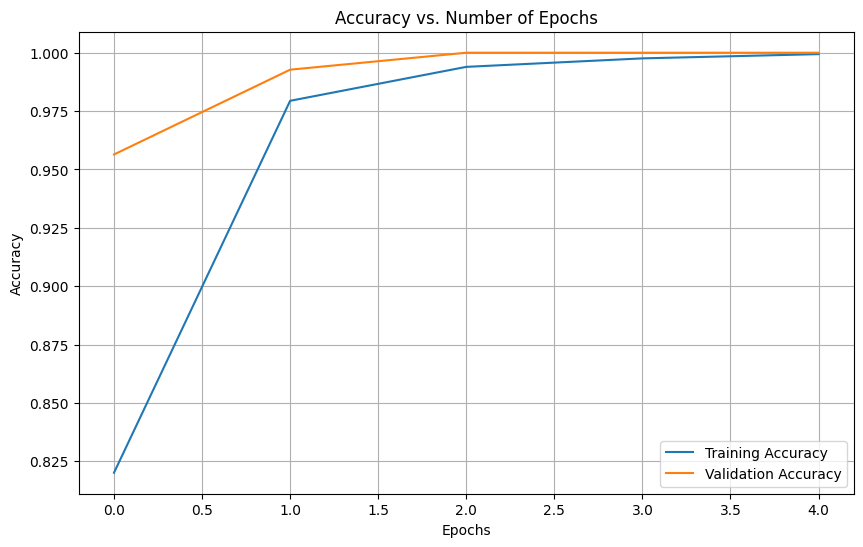

In [43]:
import matplotlib.pyplot as plt

# Assuming 'history' is the variable storing the training history
def plot_accuracy(history):
    plt.figure(figsize=(10, 6))
    
    # Plot training accuracy
    plt.plot(history.history['binary_accuracy'], label='Training Accuracy')
    
    # Plot validation accuracy
    plt.plot(history.history['val_binary_accuracy'], label='Validation Accuracy')
    
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Number of Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_accuracy(history)


I need to change my Y matrix from a single column (binary classification) to a matrix with mulitple dimensions (multi-class classification)

In [17]:
df_filtered = df[(df['season_x'] > 2017)]
df_filtered['winner'] = df_filtered['finish_position'].apply(lambda x: 1 if x == 1 else 0)

drivers_to_include = [
    "Joey_Logano", "Denny_Hamlin", "Kyle_Busch", "Martin_Truex_Jr",
    "Brad_Keselowski", "Kyle_Larson", "Ryan_Blaney", "William_Byron"]

df_filtered = df_filtered[df_filtered['driver_id'].isin(drivers_to_include)]

df_filtered['race_pole_time'] = df_filtered['race_pole_time'].replace(['NTT', 'DFP', 'MQ'], np.nan)

df_filtered = df_filtered.dropna(subset='race_pole_time')


df_filtered

C:\Users\ermun\AppData\Local\Temp\ipykernel_155488\2404990570.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['winner'] = df_filtered['finish_position'].apply(lambda x: 1 if x == 1 else 0)


,season_x,series_id_x,race_id,race_id_short,finish_position,starting_position,driver_number,driver_nationality,driver_id,driver_name,...,attendance,radio_broadcaster,television_broadcaster,master_race_id,inspection_complete,playoff_round,track_id_x,track_id_y,track_name,winner
5947,2018,W,2018_DAYTONA_500,2018_01,3,2,11,usa,Denny_Hamlin,Denny Hamlin,...,0.0,MRN,FOX,385.0,NaN,NaN,NaN,NaN,NaN,0
5948,2018,W,2018_DAYTONA_500,2018_01,4,5,22,usa,Joey_Logano,Joey Logano,...,0.0,MRN,FOX,385.0,NaN,NaN,NaN,NaN,NaN,0
5951,2018,W,2018_DAYTONA_500,2018_01,7,3,12,usa,Ryan_Blaney,Ryan Blaney,...,0.0,MRN,FOX,385.0,NaN,NaN,NaN,NaN,NaN,0
5962,2018,W,2018_DAYTONA_500,2018_01,18,24,78,usa,Martin_Truex_Jr,Martin Truex Jr,...,0.0,MRN,FOX,385.0,NaN,NaN,NaN,NaN,NaN,0
5963,2018,W,2018_DAYTONA_500,2018_01,19,38,42,usa,Kyle_Larson,Kyle Larson,...,0.0,MRN,FOX,385.0,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15482,2024,W,2024_CUP_SERIES_CHAMPIONSHIP,2024_36,4,4,5,usa,Kyle_Larson,Kyle Larson,...,0.0,MRN,NBC,1550.0,True,4.0,Phoenix_Raceway,84.0,Phoenix_Raceway,0
15489,2024,W,2024_CUP_SERIES_CHAMPIONSHIP,2024_36,11,14,11,usa,Denny_Hamlin,Denny Hamlin,...,0.0,MRN,NBC,1550.0,True,4.0,Phoenix_Raceway,84.0,Phoenix_Raceway,0
15493,2024,W,2024_CUP_SERIES_CHAMPIONSHIP,2024_36,15,27,6,usa,Brad_Keselowski,Brad Keselowski,...,0.0,MRN,NBC,1550.0,True,4.0,Phoenix_Raceway,84.0,Phoenix_Raceway,0
15495,2024,W,2024_CUP_SERIES_CHAMPIONSHIP,2024_36,17,1,19,usa,Martin_Truex_Jr,Martin Truex Jr,...,0.0,MRN,NBC,1550.0,True,4.0,Phoenix_Raceway,84.0,Phoenix_Raceway,0


In [18]:
one_hot_encoded_df = df_filtered.pivot_table(index='race_id_short', columns='driver_id', values='winner', fill_value=0)

In [19]:
one_hot_encoded_df

driver_id,Brad_Keselowski,Denny_Hamlin,Joey_Logano,Kyle_Busch,Kyle_Larson,Martin_Truex_Jr,Ryan_Blaney,William_Byron
race_id_short,,,,,,,,
2018_01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018_02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018_03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018_04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018_05,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2024_32,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2024_33,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2024_34,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
df_filtered

,season_x,series_id_x,race_id,race_id_short,finish_position,starting_position,driver_number,driver_nationality,driver_id,driver_name,...,attendance,radio_broadcaster,television_broadcaster,master_race_id,inspection_complete,playoff_round,track_id_x,track_id_y,track_name,winner
5947,2018,W,2018_DAYTONA_500,2018_01,3,2,11,usa,Denny_Hamlin,Denny Hamlin,...,0.0,MRN,FOX,385.0,NaN,NaN,NaN,NaN,NaN,0
5948,2018,W,2018_DAYTONA_500,2018_01,4,5,22,usa,Joey_Logano,Joey Logano,...,0.0,MRN,FOX,385.0,NaN,NaN,NaN,NaN,NaN,0
5951,2018,W,2018_DAYTONA_500,2018_01,7,3,12,usa,Ryan_Blaney,Ryan Blaney,...,0.0,MRN,FOX,385.0,NaN,NaN,NaN,NaN,NaN,0
5962,2018,W,2018_DAYTONA_500,2018_01,18,24,78,usa,Martin_Truex_Jr,Martin Truex Jr,...,0.0,MRN,FOX,385.0,NaN,NaN,NaN,NaN,NaN,0
5963,2018,W,2018_DAYTONA_500,2018_01,19,38,42,usa,Kyle_Larson,Kyle Larson,...,0.0,MRN,FOX,385.0,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15482,2024,W,2024_CUP_SERIES_CHAMPIONSHIP,2024_36,4,4,5,usa,Kyle_Larson,Kyle Larson,...,0.0,MRN,NBC,1550.0,True,4.0,Phoenix_Raceway,84.0,Phoenix_Raceway,0
15489,2024,W,2024_CUP_SERIES_CHAMPIONSHIP,2024_36,11,14,11,usa,Denny_Hamlin,Denny Hamlin,...,0.0,MRN,NBC,1550.0,True,4.0,Phoenix_Raceway,84.0,Phoenix_Raceway,0
15493,2024,W,2024_CUP_SERIES_CHAMPIONSHIP,2024_36,15,27,6,usa,Brad_Keselowski,Brad Keselowski,...,0.0,MRN,NBC,1550.0,True,4.0,Phoenix_Raceway,84.0,Phoenix_Raceway,0
15495,2024,W,2024_CUP_SERIES_CHAMPIONSHIP,2024_36,17,1,19,usa,Martin_Truex_Jr,Martin Truex Jr,...,0.0,MRN,NBC,1550.0,True,4.0,Phoenix_Raceway,84.0,Phoenix_Raceway,0


This represents the full multiclass dataset that can me used for a multi-class classification network.

In [21]:
fullDataEncoded = df_filtered.join(one_hot_encoded_df, on='race_id_short')
fullDataEncoded

,season_x,series_id_x,race_id,race_id_short,finish_position,starting_position,driver_number,driver_nationality,driver_id,driver_name,...,track_name,winner,Brad_Keselowski,Denny_Hamlin,Joey_Logano,Kyle_Busch,Kyle_Larson,Martin_Truex_Jr,Ryan_Blaney,William_Byron
5947,2018,W,2018_DAYTONA_500,2018_01,3,2,11,usa,Denny_Hamlin,Denny Hamlin,...,NaN,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5948,2018,W,2018_DAYTONA_500,2018_01,4,5,22,usa,Joey_Logano,Joey Logano,...,NaN,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5951,2018,W,2018_DAYTONA_500,2018_01,7,3,12,usa,Ryan_Blaney,Ryan Blaney,...,NaN,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5962,2018,W,2018_DAYTONA_500,2018_01,18,24,78,usa,Martin_Truex_Jr,Martin Truex Jr,...,NaN,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5963,2018,W,2018_DAYTONA_500,2018_01,19,38,42,usa,Kyle_Larson,Kyle Larson,...,NaN,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15482,2024,W,2024_CUP_SERIES_CHAMPIONSHIP,2024_36,4,4,5,usa,Kyle_Larson,Kyle Larson,...,Phoenix_Raceway,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
15489,2024,W,2024_CUP_SERIES_CHAMPIONSHIP,2024_36,11,14,11,usa,Denny_Hamlin,Denny Hamlin,...,Phoenix_Raceway,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
15493,2024,W,2024_CUP_SERIES_CHAMPIONSHIP,2024_36,15,27,6,usa,Brad_Keselowski,Brad Keselowski,...,Phoenix_Raceway,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
15495,2024,W,2024_CUP_SERIES_CHAMPIONSHIP,2024_36,17,1,19,usa,Martin_Truex_Jr,Martin Truex Jr,...,Phoenix_Raceway,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [22]:
# Categorical variables to include in the model
X_categorical = fullDataEncoded[['driver_nationality', 'driver_id', 'driver_name', 'sponsor', 'owner_id', 'car', 'race_track_surface', 'race_track_name']]
encoder = OneHotEncoder(sparse_output=False)
X_categorical = encoder.fit_transform(X_categorical)

# Continuous variables to include in the model
X_continuous = fullDataEncoded[['race_pole_time', 'race_speed', 'race_speed', 'pole_winner_speed', 'race_lap_len']]
scaler = StandardScaler()
X_continuous = scaler.fit_transform(X_continuous)

# Discrete variables to include in the model
X_discrete = fullDataEncoded[['finish_position', 'starting_position', 'driver_number', 'race_laps_run', 'points_earned', 'playoff_points_earned', 'race_cautions', 'race_lead_changes', 'number_of_leaders', 'number_of_caution_laps', 'race_laps_lead']]
X_discrete = scaler.fit_transform(X_discrete)

# Combine the categorical, continuous, and discrete variables into a single DataFrame
X_stacked = np.concatenate((X_categorical, X_continuous, X_discrete), axis=1)
X_stacked = pd.DataFrame(X_stacked)

y_multiClass = fullDataEncoded[['Brad_Keselowski',	'Denny_Hamlin',	'Joey_Logano',	'Kyle_Busch',	'Kyle_Larson',	'Martin_Truex_Jr',	'Ryan_Blaney',	'William_Byron']]
#y_multiClass

In [23]:
X_stacked = np.array(X_stacked)
print(X_stacked.shape[1])
y_multiClass = np.array(y_multiClass)

X_trainM, X_testM, y_trainM, y_testM = train_test_split(X_stacked, y_multiClass, test_size=0.2, random_state=42)

# Use SMOTE to handle class imbalance in the training set
smote = SMOTE(random_state=42)
X_trainM_resampled, y_trainM_resampled = smote.fit_resample(X_trainM, y_trainM)

X_trainMF, X_valMF, y_trainMF, y_valMF = train_test_split(X_trainM_resampled, y_trainM_resampled, random_state=42)

397


Use the new oneHotEncoded Y matrix to create a multi-class classification network

In [24]:
model2 = keras.Sequential()
model2.add(layers.Dense(64, input_dim = X_stacked.shape[1], activation='relu'))
model2.add(layers.Dense(32, activation='relu'))
model2.add(layers.Dense(8, activation='softmax'))

model2.compile(
    optimizer=keras.optimizers.Adam(),  # Optimizer
    # Loss function to minimize
    loss=keras.losses.BinaryCrossentropy(),
    # List of metrics to monitor
    metrics=[keras.metrics.CategoricalAccuracy()],
)


print("Fit model on training data")
history = model2.fit(
    X_trainMF,
    y_trainMF,
    batch_size=64,
    epochs=30,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(X_valMF, y_valMF),
)

Fit model on training data
Epoch 1/30


C:\Users\ermun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - categorical_accuracy: 0.1448 - loss: 0.5827 - val_categorical_accuracy: 0.1720 - val_loss: 0.3813
Epoch 2/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.2342 - loss: 0.3647 - val_categorical_accuracy: 0.4112 - val_loss: 0.3386
Epoch 3/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.4655 - loss: 0.3279 - val_categorical_accuracy: 0.4981 - val_loss: 0.3059
Epoch 4/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.5709 - loss: 0.2905 - val_categorical_accuracy: 0.6215 - val_loss: 0.2673
Epoch 5/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.6894 - loss: 0.2480 - val_categorical_accuracy: 0.6832 - val_loss: 0.2267
Epoch 6/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - categorical_accuracy: 0.7321 - loss: 0.2091 - val_categorical_accuracy: 0.7234 - val_loss: 0.1909
Epoch 7/30
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - categorical_accuracy: 0.7930 - loss: 0.1725 - val_categoric

Create a visualization that shows the improvement of accuracy over each epoch.

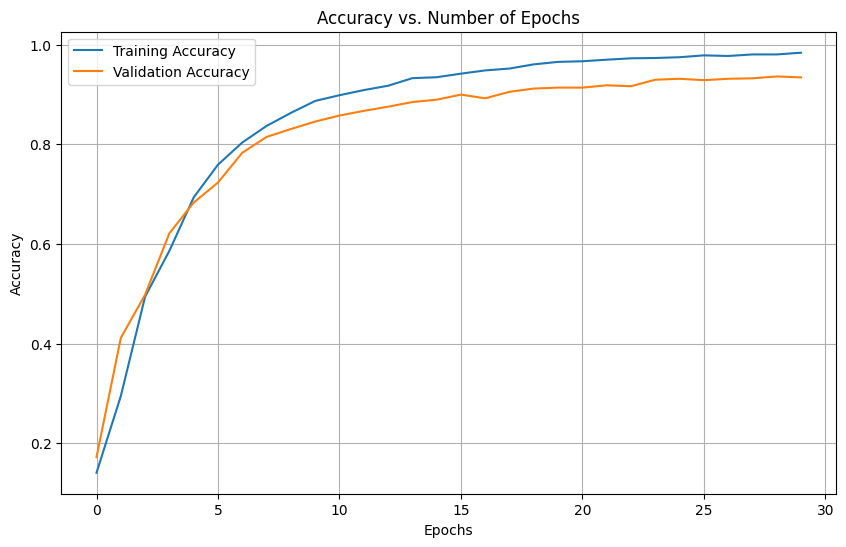

In [25]:

# Assuming 'history' is the variable storing the training history
def plot_accuracy(history):
    plt.figure(figsize=(10, 6))
    
    # Plot training accuracy
    plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
    
    # Plot validation accuracy
    plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
    
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs. Number of Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function with the history object
plot_accuracy(history)

In [26]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results2 = model2.evaluate(X_testM, y_testM, batch_size=128)
print("test loss, test acc:", results2)

# Generate predictions (probabilities -- the output of the last layer)
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions2 = model2.predict(X_valMF[:3])
print("predictions shape:", predictions2.shape)
print(predictions2)
print(y_valMF[:3]) 

Evaluate on test data
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - categorical_accuracy: 0.5337 - loss: 0.4189 
test loss, test acc: [0.40526703000068665, 0.5342960357666016]
Generate predictions for 3 samples
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
predictions shape: (3, 8)
[[1.6902894e-04 9.9943870e-01 8.1649587e-06 3.2293057e-04 1.4842072e-09
  1.8158747e-06 5.9416441e-05 2.1587139e-09]
 [2.2970159e-04 4.7231344e-05 5.1568804e-05 9.9817657e-01 1.6871871e-06
  1.4930548e-03 1.8613486e-07 1.2840738e-09]
 [1.6398035e-04 2.1750878e-08 3.1776279e-05 1.4029024e-07 2.2565885e-08
  2.4216051e-10 5.7372773e-07 9.9980360e-01]]
[[0 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1]]


In [27]:
import shap 
explainer1 = shap.KernelExplainer(model.predict, shap.sample(X_train, 3))

shap_values1 = explainer1.shap_values(X_val)

C:\Users\ermun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


  0%|          | 0/413 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  0%|          | 1/413 [00:00<05:17,  1.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  0%|          | 2/413 [00:01<06:06,  1.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  1%|          | 3/413 [00:02<05:17,  1.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  1%|          | 4/413 [00:02<04:50,  1.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step


  1%|          | 5/413 [00:03<04:32,  1.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  1%|▏         | 6/413 [00:04<04:24,  1.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  2%|▏         | 7/413 [00:04<04:17,  1.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  2%|▏         | 8/413 [00:05<04:09,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step


  2%|▏         | 9/413 [00:05<04:01,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  2%|▏         | 10/413 [00:06<04:10,  1.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  3%|▎         | 11/413 [00:07<04:13,  1.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  3%|▎         | 12/413 [00:07<04:07,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
201/201 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


  3%|▎         | 13/413 [00:08<04:07,  1.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  3%|▎         | 14/413 [00:09<04:03,  1.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


  4%|▎         | 15/413 [00:09<03:58,  1.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step


  4%|▍         | 16/413 [00:10<03:52,  1.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  4%|▍         | 16/413 [00:10<04:19,  1.53it/s]


KeyboardInterrupt: 

In [ ]:
X_val = pd.DataFrame(X_val)
shap_values1_reshaped = np.squeeze(shap_values1)
print(shap_values1_reshaped.shape, X_val.shape)

shap.initjs()

plot = shap.force_plot(explainer1.expected_value[0], shap_values1_reshaped[0], X_val.iloc[0])
display(plot)

(413, 400) (413, 400)


Save the plot of Shap values for the first Binary model to PNG

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
shap.save_html('shap1plot.html', plot)
plt.savefig("shap1plot.png")


<Figure size 640x480 with 0 Axes>